<a href="https://colab.research.google.com/github/NilsH95/colorectal-histology/blob/main/colorectal_histology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import seaborn as sns
import pandas as pd

In [2]:
# loading the dataset from tensorflow datasets
# Data Source:
# Kather JN, Weis CA, Bianconi F, Melchers SM, Schad LR, Gaiser T, Marx A, Zollner F:
# Multi-class texture analysis in colorectal cancer histology (2016), Scientific Reports (in press)

ds = tfds.load('colorectal_histology',
               split='train',
               shuffle_files=True,
               as_supervised=True)

# conversion of data to np arrays
images = []
labels = []

for image, label in tfds.as_numpy(ds):
    images.append(image)
    labels.append(label)

labels = np.array(labels)
images = np.array(images)
print(f'There are {len(labels)} data points')
print(f'The shape of the pictures is : {np.shape(images[0])}')

datapoints = len(labels)
training_split = 0.8



Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incomplete4VCJCK/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
There are 5000 data points
The shape of the pictures is : (150, 150, 3)


There are 625 datapoints of type 0
There are 625 datapoints of type 1
There are 625 datapoints of type 2
There are 625 datapoints of type 3
There are 625 datapoints of type 4
There are 625 datapoints of type 5
There are 625 datapoints of type 6
There are 625 datapoints of type 7


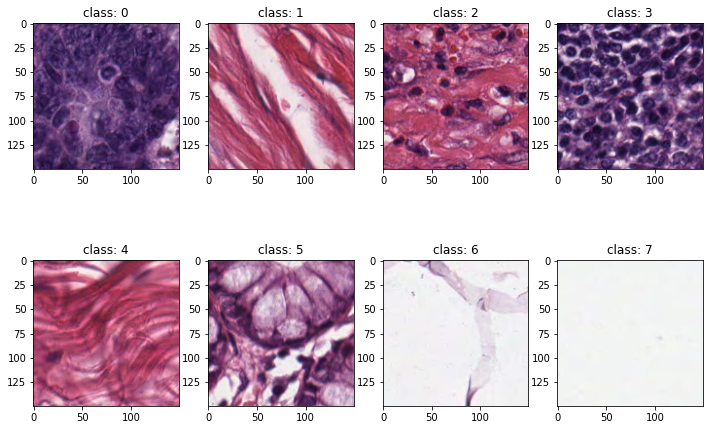

In [3]:
# searching for one image of each type for preview
index = []
for i in range(0, 8):
    print(f'There are {np.shape(np.where(labels == i))[1]} datapoints of type {i}')
    index.append(np.where(labels == i)[0][0])

# printing on picture of each class
fig3, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

for i, axi in enumerate(ax.flat):
    img = images[index[i]]
    axi.imshow(img)
    axi.set_title(f'class: {i}')

plt.show()

In [ ]:
# converting types and inputs to categorical and
# dividing data into training and validation set
images = np.array(images, dtype='float')
labels_cat = tf.keras.utils.to_categorical(labels, len(np.unique(labels)))
labels_cat = np.array(labels_cat, dtype='uint8')

imgs_training = images[:int(training_split*datapoints)]
labels_training = labels_cat[:int(training_split*datapoints)]

imgs_validation = images[int(training_split*datapoints):]
labels_validation = labels_cat[int(training_split*datapoints):]


In [ ]:
# setting training parameters
batch_size = 32
input_shape = np.shape(images[0])
epochs = 200

In [ ]:
# image augmentation and validation split
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )

valid_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(images)
train_generator = train_datagen.flow(imgs_training,
                                     labels_training,
                                     batch_size=batch_size)

validation_generator = valid_datagen.flow(imgs_validation,
                                          labels_validation,
                                          batch_size=batch_size)

In [ ]:
# model: CNN with dropout layers
model = tf.keras.models.Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(labels)*0.8 // batch_size,
    validation_data=validation_generator,
    validation_steps=len(labels)*0.2 // batch_size,
    epochs=epochs)

model.save("/tmp/model.h5")
print("Saved model to disk")

Epoch 1/200
125/125 [==============================] - 31s 185ms/step - loss: 1.6617 - accuracy: 0.3221 - val_loss: 1.0566 - val_accuracy: 0.4919
Epoch 2/200
125/125 [==============================] - 23s 181ms/step - loss: 1.1076 - accuracy: 0.5143 - val_loss: 0.8366 - val_accuracy: 0.7369
Epoch 3/200
125/125 [==============================] - 22s 180ms/step - loss: 0.8929 - accuracy: 0.6387 - val_loss: 0.8914 - val_accuracy: 0.6341
Epoch 4/200
125/125 [==============================] - 22s 178ms/step - loss: 0.8374 - accuracy: 0.6818 - val_loss: 0.7149 - val_accuracy: 0.7087
Epoch 5/200
125/125 [==============================] - 22s 179ms/step - loss: 0.7492 - accuracy: 0.7078 - val_loss: 0.6620 - val_accuracy: 0.7550
Epoch 6/200
125/125 [==============================] - 22s 176ms/step - loss: 0.7579 - accuracy: 0.7046 - val_loss: 0.6157 - val_accuracy: 0.7480
Epoch 7/200
125/125 [==============================] - 22s 174ms/step - loss: 0.6745 - accuracy: 0.7555 - val_loss: 0.6089 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


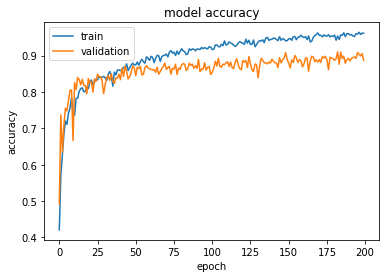

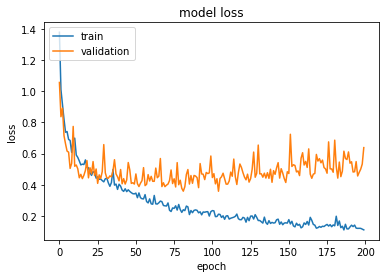

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


The validation error and loss stagnate after around 80 epochs of training. This might be an indicator of overfitting after these epochs. 

(5000, 8)
[1 0 0 0 0 0 0 0]


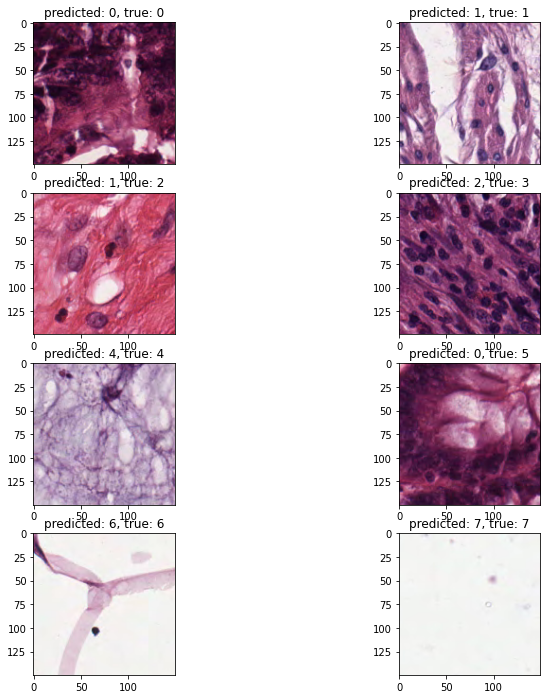

In [ ]:
print(np.shape(labels_cat))
index_val = []
print(labels_validation[0][:])

for i in range(0, 8):
    index_val.append(np.where(np.transpose(labels_validation)[i] == 1)[0][0])

# printing on picture of each class

fig2, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))

for i, axi in enumerate(ax.flat):
    img = imgs_validation[index_val[i]]
    img_pred = np.expand_dims(img, axis=0)
    img_pred = img_pred/255
    predict = model.predict(img_pred)
    img = np.array(img, dtype='int')
    axi.imshow(img)
    axi.set_title(f'predicted: {np.argmax(predict)}, true: {np.argmax(labels_validation[index_val[i]])}')

plt.show()



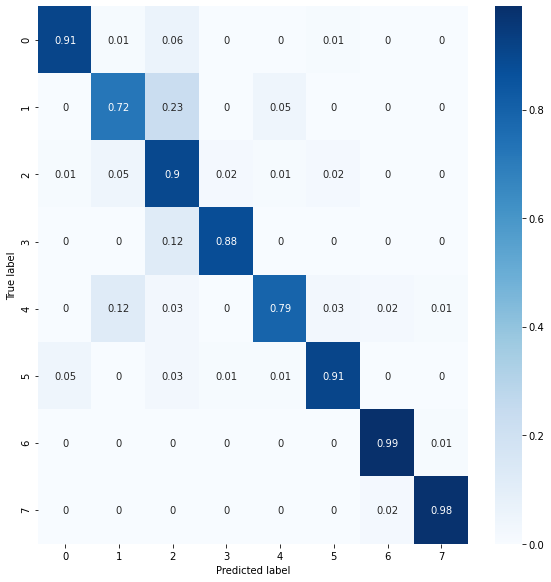

In [ ]:
imgs_predict = imgs_validation/255
val_pred = model.predict(imgs_predict)
classes = [0, 1, 2, 3, 4, 5, 6, 7]

val_pred = [np.argmax(y, axis=None, out=None) for y in val_pred]
labels_validation = [np.argmax(y, axis=None, out=None) for y in labels_validation]

con_mat = tf.math.confusion_matrix(
    labels_validation, val_pred, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()